In [1]:
# Import the libraries we'll use below.
import os
import time
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

import pydicom

from collections import deque

# Take a Look at the DICOM Image Files

### Conclusions from this section:
- There are 54706 DICOM files
- The filenames are unique even without the file paths
- From the subsample of files considered (~9%), the image files are either JPEG Lossless (Process 14, SV1) or JPEG2000 Lossless

In [10]:
# Set the directory where your DICOM files are located
dicom_directory = r"F:\rsna-breast-cancer-detection\train_images"

# Create an empty list to store file names and metadata
dicom_files = []

# Set a counter for the number of DICOM files found
count = 0

# Start the timer
start_time = time.time()

# Recursively search for DICOM files in all subdirectories
for root, dirs, files in os.walk(dicom_directory):
    for filename in files:
        # Check if the file is a DICOM file
        if filename.endswith(".dcm"):
            file_path = os.path.join(root, filename)
            # Add the data to the list
            dicom_files.append([filename, file_path])
            # Increment the counter
            count += 1
            if count % 5000 == 0:
                print(f"Processed {count} DICOM files...")
                
# Create a Pandas DataFrame from the list
df = pd.DataFrame(dicom_files, columns=["filename","file_path"])

Processed 5000 DICOM files...
Processed 10000 DICOM files...
Processed 15000 DICOM files...
Processed 20000 DICOM files...
Processed 25000 DICOM files...
Processed 30000 DICOM files...
Processed 35000 DICOM files...
Processed 40000 DICOM files...
Processed 45000 DICOM files...
Processed 50000 DICOM files...


In [11]:
output_file = "TrainingFilesList.csv"
df.to_csv(output_file, index=False)

In [12]:
df = pd.read_csv(r"C:\Users\mandy\Documents\MIDS\W207\TrainingFilesList.csv")

In [13]:
df.describe()

,filename,file_path
count,54706,54706
unique,54706,54706
top,1459541791.dcm,F:\rsna-breast-cancer-detection\train_images\1...
freq,1,1


In [14]:
df.head()

,filename,file_path
0,1459541791.dcm,F:\rsna-breast-cancer-detection\train_images\1...
1,1864590858.dcm,F:\rsna-breast-cancer-detection\train_images\1...
2,1874946579.dcm,F:\rsna-breast-cancer-detection\train_images\1...
3,462822612.dcm,F:\rsna-breast-cancer-detection\train_images\1...
4,1031443799.dcm,F:\rsna-breast-cancer-detection\train_images\1...


In [ ]:
# Make a dataframe of a subset of files that includes transfer syntax uid
# This is to understand what format the compressed pixel data is in
# to understand what packages we might need
# see https://pydicom.github.io/pydicom/stable/old/image_data_handlers.html

# Create a deque to store the data
dicom_data = deque()

# Set the directory where your DICOM files are located
dicom_directory = r"F:\rsna-breast-cancer-detection\train_images"

# Set a counter for the number of DICOM files found
count = 0

# Start the timer
start_time = time.time()

# Recursively search for DICOM files in all subdirectories
for root, dirs, files in os.walk(dicom_directory):
    for filename in files:
        # Check if the file is a DICOM file
        if filename.endswith(".dcm"):
            # Use PyDicom to read the file
            dicom_file = pydicom.dcmread(os.path.join(root, filename))
            # Extract the file name and Transfer Syntax UID
            file_name = filename
            transfer_syntax_uid = dicom_file.file_meta.TransferSyntaxUID
            # Add the data to the list
            dicom_data.append([file_name, transfer_syntax_uid])
            # Increment the counter
            count += 1
            if count % 100 == 0:
                print(f"Processed {count} DICOM files...")
            # Check if the count has reached 5000 and exit the loop if it has
            if count == 5000:
                break
    # Check if the count has reached 5000 and exit the loop if it has
    if count >= 5000:
        break

# Stop the timer
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Processed 5000 DICOM files in {elapsed_time:.2f} seconds")
        
# Create a Pandas DataFrame from the list
df2 = pd.DataFrame(dicom_data, columns=["file_name", "transfer_syntax_uid"])

In [ ]:
# Save information into a file for future reference
output_file = "TrainingCompressionType_subset.csv"
df2.to_csv(output_file, index=False)

In [ ]:
df2 = pd.read_csv(r"C:\Users\mandy\Documents\MIDS\W207\TrainingSubsetInfo.csv")

<AxesSubplot:>

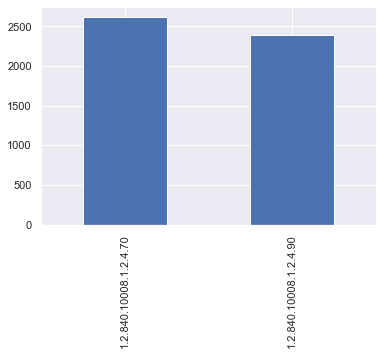

In [6]:
# Look at proportions of each type for this subset
df2['transfer_syntax_uid'].value_counts().plot(kind='bar')

In [7]:
# Get list of unique types
unique_transfer_syntax_uids = df2['transfer_syntax_uid'].unique()
print(unique_transfer_syntax_uids)

['1.2.840.10008.1.2.4.90' '1.2.840.10008.1.2.4.70']


In [4]:
df2.head()

,file_name,transfer_syntax_uid
0,1459541791.dcm,1.2.840.10008.1.2.4.90
1,1864590858.dcm,1.2.840.10008.1.2.4.90
2,1874946579.dcm,1.2.840.10008.1.2.4.90
3,462822612.dcm,1.2.840.10008.1.2.4.90
4,1031443799.dcm,1.2.840.10008.1.2.4.90


In [8]:
# Get a sample file for each transfer_syntax_uid type
example_types_indices = []

for uid in unique_transfer_syntax_uids:
    example_types_indices.append(df2.loc[df2['transfer_syntax_uid'] == uid].index[0])
    
print(example_types_indices)

[0, 12]


# Look at a few images with the pydicom package

### Conclusions in this section
- Able to look at both types of compression identified in previous section
- Note: an unofficial package was installed: pip install -U python-gdcm
- The metadata has information about file type (ex JPEG Lossless..), date/time stamps,  patient ID, measurement information, images sizes, pixel information, and more
- The images vary in aspect ratio, amount of breast shown, how the breast is centered. Obviously there is also left and right breast which are labeled.
- From the subset of images looked at, laterality seems to match expectations where L means the larger part of the breast is on the left and vice versa. 

In [15]:
# Load the DICOM images
# Use the examples identified in the previous section that have different file types
ds_list = []

for ind in example_types_indices:
    ds_list.append(pydicom.dcmread(df.iloc[ind,1]))

In [16]:
# Double check what transfer syntax UIDs are on the files considered
for ds in ds_list:
    print(ds.file_meta.TransferSyntaxUID)

1.2.840.10008.1.2.4.90
1.2.840.10008.1.2.4.70


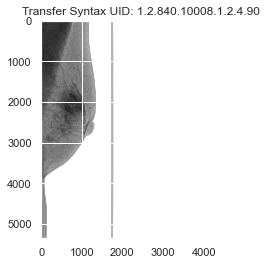

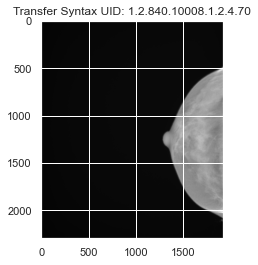

In [17]:
# Extract the pixel data from the DICOM images
for ds in ds_list:
    pixel_data = ds.pixel_array

    # Display the image using matplotlib
    plt.imshow(pixel_data, cmap=plt.cm.gray)
    plt.title('Transfer Syntax UID: {}'.format(ds.file_meta.TransferSyntaxUID))
    plt.show()

In [18]:
# Look at the metadata
# More information at this link: https://www.dicomlibrary.com/dicom/dicom-tags/
print(ds)

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.10009.1.2.3.10038.1.1350492010
(0002, 0010) Transfer Syntax UID                 UI: JPEG Lossless, Non-Hierarchical, First-Order Prediction (Process 14 [Selection Value 1])
(0002, 0012) Implementation Class UID            UI: 1.2.840.113654.2.3.1995.2.12.0
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.840.10009.1.2.3.10038.1.1350492010
(0008, 0023) Content Date                        DA: '20221118'
(0008, 0033) Content Time                        TM: '183910.522969'
(0010, 0020) Patient ID                          LO: '10038'
(0018, 11a0) Body Part Thickness                 DS: '32.0'
(0

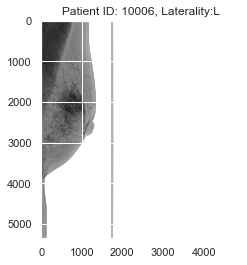

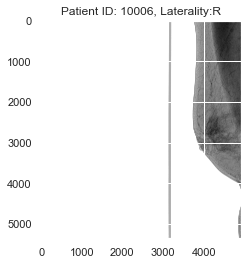

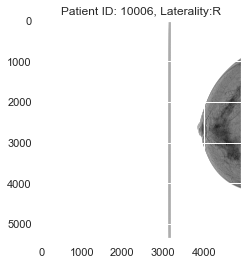

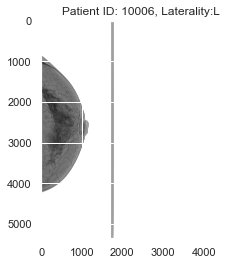

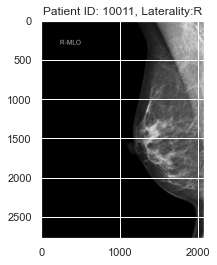

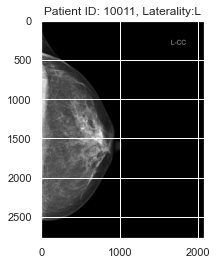

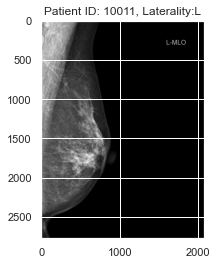

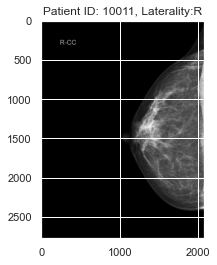

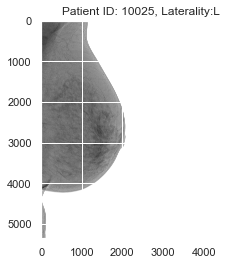

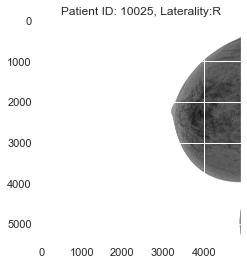

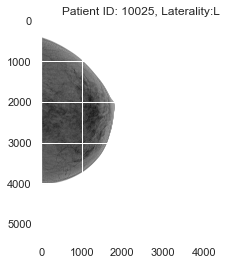

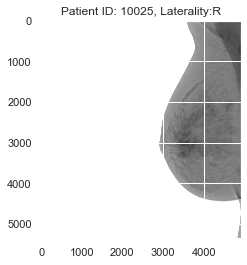

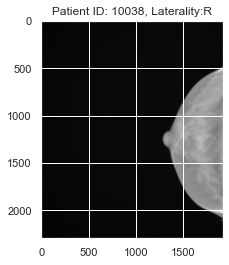

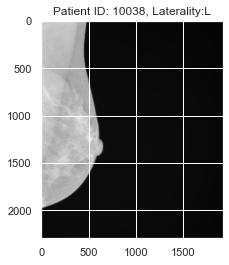

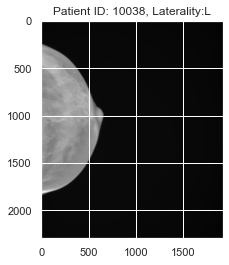

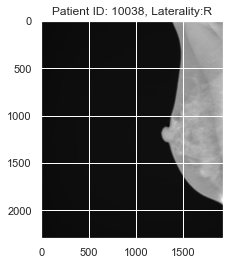

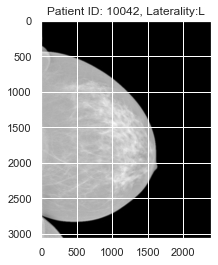

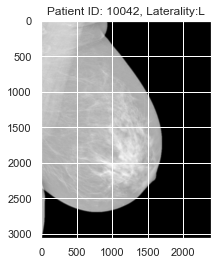

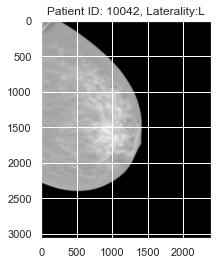

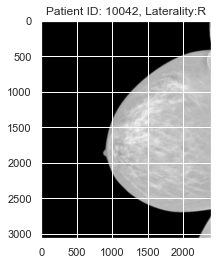

In [19]:
# Plot a few more images
# Extract the pixel data from the DICOM images
for ind in range(20):
    ds = pydicom.dcmread(df.iloc[ind,1])
    pixel_data = ds.pixel_array

    # Display the image using matplotlib
    plt.imshow(pixel_data, cmap=plt.cm.gray)
    plt.title('Patient ID: {}, Laterality:{}'.format(ds.PatientID, ds.ImageLaterality))
    plt.show()